In [ ]:
!pip install patchify

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sepide242477","key":"d1ec2f06a5ab676086672c24f346ca43"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [6]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

 20% 6.00M/29.6M [00:00<00:00, 61.5MB/s]
100% 29.6M/29.6M [00:00<00:00, 175MB/s] 


In [ ]:
!unzip '/content/semantic-segmentation-of-aerial-imagery.zip'

# preproscess dataset

In [1]:
import os 
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image
import matplotlib.pyplot as plt 
from patchify import patchify
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
scaler=MinMaxScaler()
rootDir='/content/Semantic segmentation dataset/'
patch_size = 256

In [ ]:
image_dataset = []  
for path, subdirs, files in os.walk(rootDir):
     
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images': 
        images = os.listdir(path) 
        images=np.sort(images)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   
                image = cv2.imread(path+"/"+image_name, 1)  
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y)) 
                image = np.array(image)             
       
               
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                         
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)


In [ ]:
mask_dataset = []  
for path, subdirs, files in os.walk(rootDir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':  
        masks = os.listdir(path) 
        masks=np.sort(masks)
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):  
                mask = cv2.imread(path+"/"+mask_name, 1)  
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  
            
                mask = np.array(mask)             
       
               
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:] 
                        single_patch_mask = single_patch_mask[0]                                
                        mask_dataset.append(single_patch_mask) 

In [18]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)

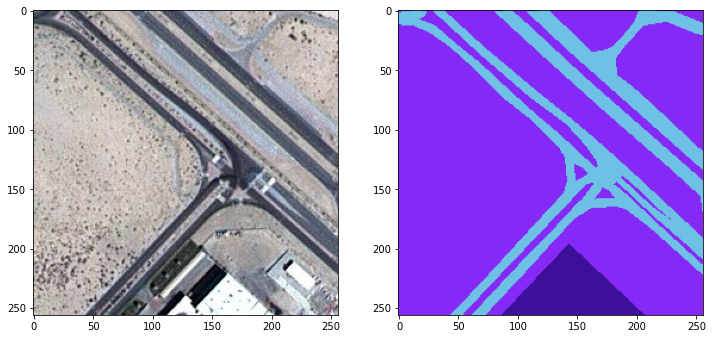

In [6]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

### **HEX to rgb **

In [19]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [20]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    label_seg = label_seg[:,:,0] 
    return label_seg

In [21]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [22]:
labels.shape

(1305, 256, 256, 1)

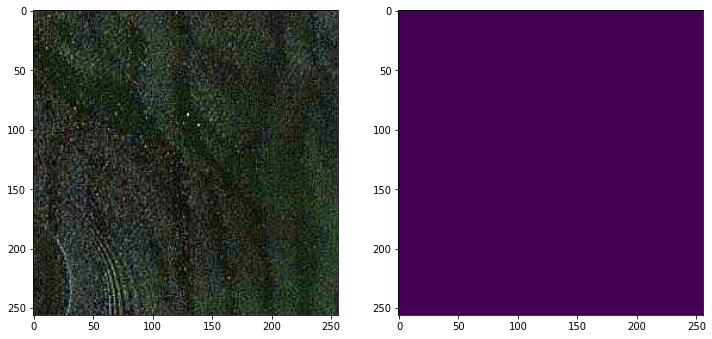

In [23]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# creat model 

In [ ]:
!pip install segmentation_models

In [24]:
import tensorflow as tf 

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import UpSampling2D,Concatenate,Conv2D,Input
from tensorflow.keras.metrics import MeanIoU
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [26]:
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [27]:
import segmentation_models as sm

In [28]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [29]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  
metrics=['accuracy', jacard_coef]

In [30]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [32]:
# creat model 
input=Input(shape=(256,256,3))
vgg=VGG16(weights='imagenet',include_top=False,input_tensor=input)

c1=vgg.get_layer('block3_pool').output
c2=vgg.get_layer('block4_pool').output
c3=vgg.get_layer('block5_pool').output

u1=UpSampling2D((2,2),interpolation='bilinear')(c3)
d1=Concatenate()([u1,c2])
d1=Conv2D(256,1,activation='sigmoid')(d1)

u2=UpSampling2D((2,2),interpolation='bilinear')(d1)
d2=Concatenate()([u2,c1])
d2=Conv2D(256,1,activation='sigmoid')(d2)

u3=UpSampling2D((8,8),interpolation='bilinear')(d2)
outputs=Conv2D(1,1,activation='sigmoid')(u3)

model=Model(input,outputs)

In [33]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [ ]:
history1 = model.fit(image_dataset, labels_cat, 
                    batch_size = 16, 
                    verbose=1,
                    validation_split=0.25, 
                    epochs=100)